In [ ]:
path = "/home/ziran/se3/EFEM/data/ShapeNetV1_SDF/03797390/1a1c0a8d4bad82169f0594e65f756cf5/pointcloud.npz"
import numpy as np

# 加载 .npz 文件
data = np.load(path)
# 查看文件中的内容
print("Keys in the NPZ file:", data.files)

# 检查每个键的数据类型和形状
for key in data.files:
    print(f"Key: {key}")
    print("Data type:", type(data[key]))
    print("Shape:", data[key].shape)
    print("---")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 加载数据
points = data['points']

# 随机选取点云的一个子集
# 例如，选取总点数的 10%
sample_size = int(len(points) * 1)
indices = np.random.choice(len(points), sample_size, replace=False)
points = points[indices]

# 创建 3D 图形
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制点云
ax.scatter(points[:, 0], points[:, 1], points[:, 2])

# 设置坐标轴标签
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

# 显示图形
plt.show()

In [ ]:
len(points) 

In [ ]:
# 这样搞得mesh如月球表面, 而且有奇怪的一个横贯的长表面

# import open3d as o3d
# import numpy as np

# # 加载点云数据
# point_cloud = o3d.geometry.PointCloud()
# point_cloud.points = o3d.utility.Vector3dVector(points)

# # 可选：估算法线
# point_cloud.estimate_normals()

# # 使用泊松表面重建创建网格
# mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(point_cloud, depth=9)[0]

# # 保存网格为 OBJ 文件
# o3d.io.write_triangle_mesh("output_mesh.obj", mesh)


In [ ]:
import open3d as o3d
import numpy as np

# 加载点云数据
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(points)

# Step 2: Estimate normals
point_cloud.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

# Step 3: Create mesh (using Ball Pivoting here)
# radii = [0.005, 0.01, 0.02, 0.04]
radii = [0.02, 0.03, 0.04] 
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
       point_cloud, o3d.utility.DoubleVector(radii))

# Step 4: Save mesh
o3d.io.write_triangle_mesh("output_mesh.obj", mesh)



## use multi camera

In [1]:
import pybullet as p
import numpy as np
from multi_camera import MultiCamera




p.connect(p.DIRECT)  # 或 p.GUI，视您的需求而定

# plane_id = p.loadURDF("plane.urdf")  # 直接加载标准平面模型

# 加载您刚刚创建的 URDF 文件
mesh_id = p.loadURDF("mesh.urdf")



# 初始化相机视图
cam_yaws = [-30, 10, 50, 90, 130, 170, 210]
cam_pitches = [-70, -10, -65, -40, -10, -25, -60]
cam_dist = 0.85
cam_target = np.array([0.35, 0, 0])

your_object_ids = 0
# 渲染图像
rendered_images = MultiCamera.render(
    sim=p,  # PyBullet 实例
    object_ids=[your_object_ids],  # 你加载的物体的ID列表
    cam_yaws=cam_yaws,
    cam_pitches=cam_pitches,
    cam_dist=cam_dist,
    cam_target=cam_target,
    views=[2],  # 选择要渲染的视图索引
    width=100,  # 图像宽度
    height=100  # 图像高度
)

# 获取渲染的图像
images = rendered_images['images']
# 可以进行进一步的处理或显示这些图像


pybullet build time: May 28 2020 16:37:34
b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
base_linkb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
base_link

In [ ]:
import trimesh
import ipyvolume as ipv

# 加载OBJ文件
mesh = trimesh.load('output_mesh.obj')
# 可视化网格
ipv.figure()
ipv.plot_trisurf(mesh.vertices[:,0], mesh.vertices[:,1], mesh.vertices[:,2], triangles=mesh.faces)
ipv.show()


In [1]:
import pybullet as p
import numpy as np

# 初始化 PyBullet
p.connect(p.DIRECT)

# 加载模型
# model_id = p.loadURDF("path/to/your/model.urdf")
mesh_id = p.loadURDF("mesh.urdf")

# 设置摄像机参数
width, height = 640, 480
fov, aspect, nearplane, farplane = 60, width / height, 0.1, 100
viewMatrix = p.computeViewMatrixFromYawPitchRoll(cameraTargetPosition=[0, 0, 0],
                                                 distance=1,
                                                 yaw=90,
                                                 pitch=-10,
                                                 roll=0,
                                                 upAxisIndex=2)
projectionMatrix = p.computeProjectionMatrixFOV(fov, aspect, nearplane, farplane)

# 获取图像
_, _, _, depthImg, segImg = p.getCameraImage(width,
                                             height,
                                             viewMatrix,
                                             projectionMatrix,
                                             shadow=True,
                                             renderer=p.ER_BULLET_HARDWARE_OPENGL)

# 计算点云
depthBuffer = np.reshape(depthImg, (height, width))
far = farplane
near = nearplane
depth = far * near / (far - (far - near) * depthBuffer)
x = np.linspace(-1, 1, width)
y = np.linspace(-1, 1, height)
x, y = np.meshgrid(x, -y)

z = depth
x = x * z
y = y * z
pointCloud = np.dstack((x, y, z))

# 这里你可以添加计算法线的代码

# 断开 PyBullet 连接
p.disconnect()


pybullet build time: May 28 2020 16:37:34
b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
base_link

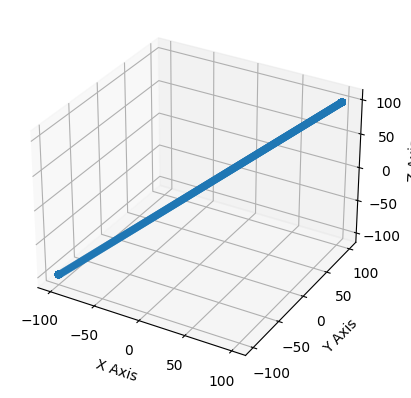

In [4]:
import numpy as np
import matplotlib.pyplot as plt
points = pointCloud
# 创建 3D 图形
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制点云
ax.scatter(points[:, 0], points[:, 1], points[:, 2])

# 设置坐标轴标签
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

# 显示图形
plt.show()